# Interacting with the JWST pipeline --- an Introduction
**Author**: Néstor Espinoza (nespinoza@stsci.edu) | **Date of last update:** June 23, 2021

## 0. Preamble

To run this notebook, you will need the following Python libraries:

- `numpy` (`pip install numpy`).
- `matplotlib (`pip install matplotlib`).
- The `astropy` library (`pip install astropy`).
- The `jwst` pipeline library (`pip install jwst`).

With that, you should be all set! The following should import everything without problems:

In [1]:
# Need to set these enviromental variables for this notebook to work properly:
%set_env CRDS_PATH $HOME/crds_cache
%set_env CRDS_SERVER_URL https://jwst-crds.stsci.edu

# Import all useful libraries:
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits

from jwst.pipeline import calwebb_detector1
from jwst.pipeline import calwebb_spec2

env: CRDS_PATH=$HOME/crds_cache
env: CRDS_SERVER_URL=https://jwst-crds.stsci.edu


2021-06-23 10:37:56,815 - stpipe - WARNING - /Users/nespinoza/miniconda2/envs/newen/lib/python3.7/site-packages/photutils/detection/findstars.py:35: AstropyDeprecationWarning: _StarFinderKernel was moved to the photutils.detection._utils module. Please update your import statement.
  AstropyDeprecationWarning)



## 1. Introduction

In the following notebook, we will perform some data analysis using the JWST pipeline and our own scripts, in order to showcase how flexible and modular the pipeline is. Above, we have imported the `calwebb_detector1` and `calwebb_spec2` classes, which contain functions from Stage 1 (detector processing) and Stage 2 (spectroscopic processing), respectively. 

To execute this notebook, you will need to download the `Uncalibrated` data from NIRISS/SOSS [here](https://stsci.box.com/s/8r6kqh9m53jkwkff0scmed6zx42g307e). In particular, let's use the `WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits` file --- the second segment of uncalibrated data. Save it wherever you are running this notebook, and the cells below should run without issues.

## 2. Running Stage 1 steps individually

The JWST pipeline Stages are divided into steps. [For Stage 1, the list of steps is on the JWST Pipeline ReadTheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html). The first step in Stage 1 of the pipeline is the `group_scale` step which in our case won't do anything to our data --- but the next one, the `dq_init` step, will. This step populates the data-quality flags in each of our groups. Let's apply this, and only this step to our data and see what we get.

To apply a step, we can simply call it from `calwebb_detector1`; we give the input file, and add any flags we want. In our case, we'll define an output directory to save the results to a file:

In [2]:
# Create output directory:
os.mkdir('pipeline_outputs_directory')

# Run step:
dq_results = calwebb_detector1.dq_init_step.DQInitStep.call('WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits', 
                                                             output_dir='pipeline_outputs_directory', 
                                                             save_results=True)

2021-06-23 10:38:02,173 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2021-06-23 10:38:02,791 - stpipe.DQInitStep - INFO - Step DQInitStep running with args ('WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits',).
2021-06-23 10:38:02,793 - stpipe.DQInitStep - INFO - Step DQInitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'pipeline_outputs_directory', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-06-23 10:38:05,241 - stpipe.DQInitStep - INFO - Using MASK reference file $HOME/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits
2021-06-23 10:38:10,790 - stpipe.DQInitStep - INFO - Extracting mask subarray to match science data
2021-06-23 10:38:22,325 - stpipe.DQInitStep - INFO - Saved model in pipeline_outputs_directory/WASP43_NIS_SOSS-seg002_CLEAR_dqinitstep.fits
2021-06-23 10:38:22,331 - stpipe.DQInit

Note that in your first run of the JWST pipeline, you will probably see much more outputs than the ones above. That's normal.

All right! The `DQInitStep` has went through successfully. What did it do? Let's compare the before and after:

In [3]:
data_before = fits.open('WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits')
print('Before:')
print(data_before.info())

data_after = fits.open('pipeline_outputs_directory/WASP43_NIS_SOSS-seg002_CLEAR_dqinitstep.fits')
print('\nAfter:')
print(data_after.info())

Before:
Filename: WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     124   ()      
  1  SCI           1 ImageHDU        48   (2048, 256, 6, 107)   int16 (rescales to uint16)   
  2  ZEROFRAME     1 ImageHDU        12   (2048, 256, 107)   int16 (rescales to uint16)   
  3  GROUP         1 BinTableHDU     36   642R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  4  INT_TIMES     1 BinTableHDU     24   320R x 7C   [J, D, D, D, D, D, D]   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [6587B]   
None

After:
Filename: pipeline_outputs_directory/WASP43_NIS_SOSS-seg002_CLEAR_dqinitstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     142   ()      
  1  SCI           1 ImageHDU        46   (2048, 256, 6, 107)   float32   
  2  PIXELDQ       1 ImageHDU        11   (2048, 256)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU  

All this looks perfect. There was a handful of new `Name`s added to the file, including the `PIXELDQ` and `GROUPDQ` (feel free to explore those --- a list of what each data quality (DQ) flag means can be found [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/references_general/references_general.html#data-quality-flags)).

### An alternative way of doing the same

An alternative way of running the same line as above is by doing:

In [4]:
from jwst.dq_init import DQInitStep

DQInitStep.call('WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits', 
                 output_dir='pipeline_outputs_directory', 
                 output_file='WASP43_NIS_SOSS-seg002_CLEAR_dqinitstep_alt',
                 save_results=True)

2021-06-23 10:38:27,366 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2021-06-23 10:38:28,726 - stpipe.DQInitStep - INFO - Step DQInitStep running with args ('WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits',).
2021-06-23 10:38:28,728 - stpipe.DQInitStep - INFO - Step DQInitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/nespinoza/Documents/niriss-commissioning/nis_comm/nis_034/datareduction/WASP43_NIS_SOSS-seg002_CLEAR_dqinitstep_alt', 'output_dir': 'pipeline_outputs_directory', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-06-23 10:38:31,112 - stpipe.DQInitStep - INFO - Using MASK reference file $HOME/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits
2021-06-23 10:38:34,893 - stpipe.DQInitStep - INFO - Extracting mask subarray to match science data
2021-06-23 10:38:47,999 - stpipe.DQInitStep - INFO - Saved 

<RampModel(107, 6, 256, 2048) from WASP43_NIS_SOSS-seg002_CLEAR_dqinitstep_alt_dqinitstep.fits>

Which one to use is, of course, up to the user!

### Pipeline steps inputs

Now, note that it is not necessary to always pass filenames as inputs to run a step. You can also pass to steps the outputs from previous steps. For instance, the next step after the `dq_init` step is the `saturation` step --- let's run that by passing the outputs obtained above for the `dq_init` step:

In [5]:
saturation_results = calwebb_detector1.saturation_step.SaturationStep.call(dq_results, 
                                                                           output_dir='pipeline_outputs_directory', 
                                                                           save_results=True)

2021-06-23 10:38:48,074 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2021-06-23 10:38:48,743 - stpipe.SaturationStep - INFO - Step SaturationStep running with args (<RampModel(107, 6, 256, 2048) from WASP43_NIS_SOSS-seg002_CLEAR_dqinitstep.fits>,).
2021-06-23 10:38:48,745 - stpipe.SaturationStep - INFO - Step SaturationStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'pipeline_outputs_directory', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-06-23 10:38:48,774 - stpipe.SaturationStep - INFO - Using SATURATION reference file $HOME/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-23 10:38:48,885 - stpipe.SaturationStep - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-23 10:38:54,288 - stpipe.SaturationStep - 

As we'll see below, this simplifies a lot the data reduction when many steps want to be ran one after the other.

## 3. Running Stage 1 steps _en masse_

A natural extension of trying to run pipeline steps one-by-one is to figure out how to run a series of them. There are a series of ways of doing this, but the one I find the easiest is to put the function calls in python `list`'s (yes, you can list _functions_ in a list in Python, which is pretty incredible) --- and then run them one-by-one with a for loop.

For example, let's run all the steps up to the `superbias` step of Stage 1 using this technique:

In [6]:
# Define steps we want to run our data through:
steps = [calwebb_detector1.dq_init_step.DQInitStep.call,
         calwebb_detector1.saturation_step.SaturationStep.call,
         calwebb_detector1.superbias_step.SuperBiasStep.call]

# Define input on the first iteration of the loop below:
calwebb_input = 'WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits'

for i in range(len(steps)):
    
    # Developers would not be very happy with me using several times the same variable as input/output, 
    # but we are astronomers --- note calwebb_input in the first iteration is a string, then is an object:
    calwebb_input = steps[i](calwebb_input, 
                             output_dir='pipeline_outputs_directory', 
                             output_file='enmasse')

2021-06-23 10:39:20,220 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2021-06-23 10:39:20,992 - stpipe.DQInitStep - INFO - Step DQInitStep running with args ('WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits',).
2021-06-23 10:39:20,995 - stpipe.DQInitStep - INFO - Step DQInitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/nespinoza/Documents/niriss-commissioning/nis_comm/nis_034/datareduction/enmasse', 'output_dir': 'pipeline_outputs_directory', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-06-23 10:39:25,529 - stpipe.DQInitStep - INFO - Using MASK reference file $HOME/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits
2021-06-23 10:39:34,904 - stpipe.DQInitStep - INFO - Extracting mask subarray to match science data
2021-06-23 10:39:48,646 - stpipe.DQInitStep - INFO - Saved model in pipeline_outputs_directory

Neat, huh? Just for fun, let's see how our superbias-corrected groups look like:

In [7]:
uncal_data = fits.open('WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits')
uncal_first_group_first_integration = uncal_data['SCI'].data[0,0,:,:]

corrected_data = fits.open('pipeline_outputs_directory/enmasse_superbiasstep.fits')
cal_first_group_first_integration = corrected_data['SCI'].data[0,0,:,:]

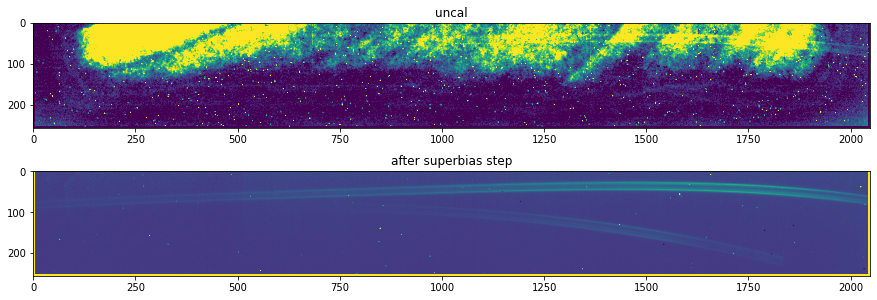

In [8]:
plt.figure(figsize=(15,5))

plt.subplot(211)
plt.title('uncal')
im = plt.imshow(uncal_first_group_first_integration)
im.set_clim(10000,15000)
plt.subplot(212)
plt.title('after superbias step')
im2 = plt.imshow(cal_first_group_first_integration)
im2.set_clim(-2000,3000)

That _looks_ nice at first. But the reference pixels (yellow edges) look surprisingly offset in counts --- which is typically not a good sign.

## 4. Overriding reference files

While the superbias correction above looks _good_ in the image, I did cheat a little bit: there is a huge offset in the reference pixels of the final corrected image after applying the superbias step. This can be checked by plotting one column --- say, column 1000, of the superbias-corrected image:

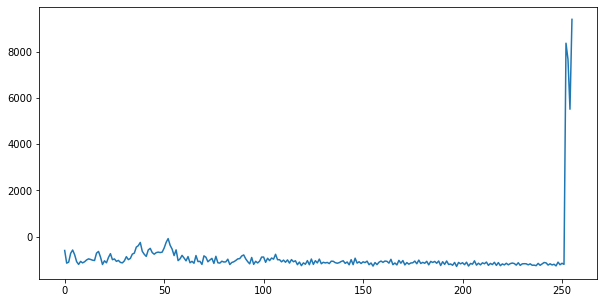

In [9]:
plt.figure(figsize=(10,5))
plt.plot(cal_first_group_first_integration[:,1000])

The counts reaching negative values is not really a big issue (can happen; there can be bias offsets on a group-to-group level --- this is why reference pixels are so useful!). However, the reference pixels --- pixels in rows 252, 253, 254 and 255 in the plot above, also seen at the bottom and edges of the image above (the "after superbias step" image) --- have a huge offset with the data in the detector. This _is_ an issue. What's going on?

Well, if one reads the [`README.md` file we wrote for the NIRISS simulated data](https://stsci.box.com/s/jx9bh86015qnutw63u1nt0mh2iq3mywp), an important piece of information in there is that the reference file to generate the simulations was `jwst_niriss_superbias_0017.fits`. However, if you scroll above to the outputs of the pipeline, the reference file used to simulate the data was the `jwst_niriss_superbias_0018.fits` file! Nothing wrong with the pipeline, of course; it's only using the _latest_ reference file. But in our case, this is an issue. 

Do not despair, however; it's very easy to override the reference file to use another one. It's simply an argument of the `SuperBiasStep.call` function call above. You need, however, to download the corresponding reference file. This is also easy to do!

Let's first download the correct reference file:

In [10]:
from astropy.utils.data import download_file

file_path = download_file('https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_niriss_superbias_0017.fits')
os.rename(file_path, 'jwst_niriss_superbias_0017.fits')

And let's now run the `superbias` step with this reference file:

In [11]:
sbias_corrected = calwebb_detector1.superbias_step.SuperBiasStep.call('pipeline_outputs_directory/enmasse_saturationstep.fits', 
                                                     output_dir='pipeline_outputs_directory', 
                                                     output_file='good_reference_file',
                                                     override_superbias = "jwst_niriss_superbias_0017.fits")

2021-06-23 10:40:26,045 - stpipe.SuperBiasStep - INFO - SuperBiasStep instance created.
2021-06-23 10:40:27,534 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep running with args ('pipeline_outputs_directory/enmasse_saturationstep.fits',).
2021-06-23 10:40:27,536 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/nespinoza/Documents/niriss-commissioning/nis_comm/nis_034/datareduction/good_reference_file', 'output_dir': 'pipeline_outputs_directory', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-06-23 10:40:31,095 - stpipe.SuperBiasStep - INFO - Using SUPERBIAS reference file /Users/nespinoza/Documents/niriss-commissioning/nis_comm/nis_034/datareduction/jwst_niriss_superbias_0017.fits
2021-06-23 10:40:47,737 - stpipe.SuperBiasStep - INFO - Saved model in pipeline_outputs_directory

All right! Let's see how we did:

In [12]:
good_corrected_data = fits.open('pipeline_outputs_directory/good_reference_file_superbiasstep.fits')
good_cal_first_group_first_integration = good_corrected_data['SCI'].data[0,0,:,:]

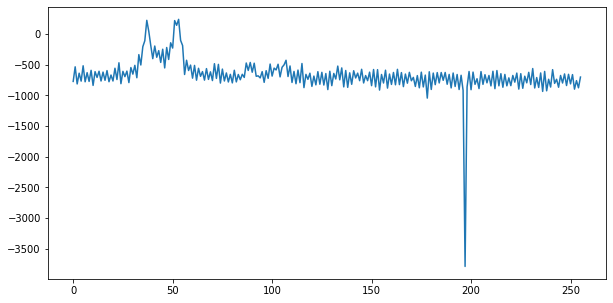

In [13]:
plt.figure(figsize=(10,5))
plt.plot(good_cal_first_group_first_integration[:,1000])

Nice --- the reference pixels are back to normal!

## 5. Changing pipeline parameters

Changing pipeline parameters is also very easy to do. Let's try changing parameters in the `refpix` step --- the reference pixel correction step. 

In the previous plot, you probably noticed that there are some high-frequency variations in the data. These are so-called "odd-even" effects in the detector, and they are captured pretty well by the reference pixels in the sides of it. Let's plot those so you can see them directly:

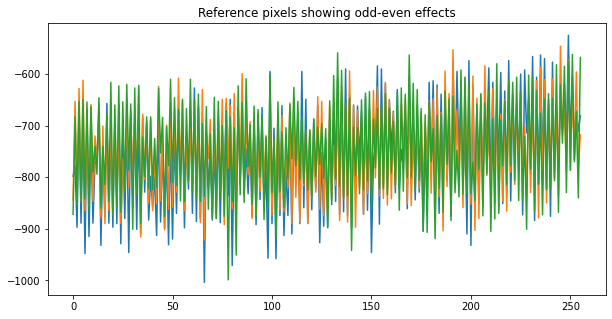

In [14]:
plt.figure(figsize=(10,5))
plt.title('Reference pixels showing odd-even effects')
plt.plot(good_cal_first_group_first_integration[:,2046])
plt.plot(good_cal_first_group_first_integration[:,2045])
plt.plot(good_cal_first_group_first_integration[:,2044])

It's called odd-even because among rows and among columns, the signal is fairly smooth. Let's plot one row of these reference pixels, taking only the even, the odd and all the rows so we can see this better:

(0.0, 256.0)

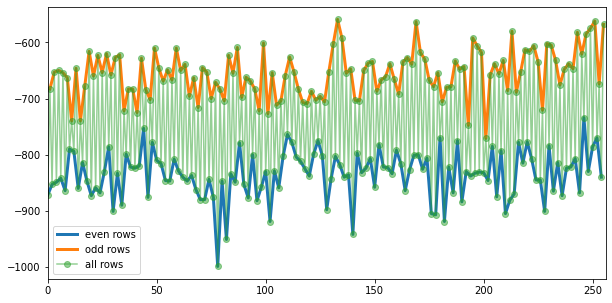

In [15]:
plt.figure(figsize=(10,5))
even = np.arange(0,256,2)
odd = np.arange(1,256,2)

plt.plot(even, good_cal_first_group_first_integration[even,2044], lw=3, label='even rows')
plt.plot(odd, good_cal_first_group_first_integration[odd,2044],lw=3, label='odd rows')
plt.plot(good_cal_first_group_first_integration[:,2044],'-o',alpha=0.5, label='all rows')
plt.legend()
plt.xlim(0,256)

The JWST pipeline's `refpix` step handles this correction by computing a running median as a function of row on each side of the detector with a height (window) of `side_smoothing_length=11` pixels by default. Let's try the same correction, but let's play with the smoothing length and see what results we get on column 1000. Let's try with smoothing lengths of 5, 8, 11 and 14 to see if we spot any differences in the final product:

In [16]:
for smoothing_length in [5,8,11,14]:
    refpix_corrected = calwebb_detector1.refpix_step.RefPixStep.call(sbias_corrected, 
                                                     output_dir='pipeline_outputs_directory', 
                                                     output_file='smooth_length_'+str(smoothing_length),
                                                     side_smoothing_length=smoothing_length)

2021-06-23 10:40:48,459 - stpipe.RefPixStep - INFO - RefPixStep instance created.
2021-06-23 10:40:49,163 - stpipe.RefPixStep - INFO - Step RefPixStep running with args (<RampModel(107, 6, 256, 2048) from good_reference_file_superbiasstep.fits>,).
2021-06-23 10:40:49,165 - stpipe.RefPixStep - INFO - Step RefPixStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/nespinoza/Documents/niriss-commissioning/nis_comm/nis_034/datareduction/smooth_length_5', 'output_dir': 'pipeline_outputs_directory', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 5, 'side_gain': 1.0, 'odd_even_rows': True}
2021-06-23 10:40:49,180 - stpipe.RefPixStep - INFO - use_side_ref_pixels = True
2021-06-23 10:40:49,181 - stpipe.RefPixStep - INFO - odd_even_columns = True
2021-06-23 10:40:4

All right, let's see how each of them did:

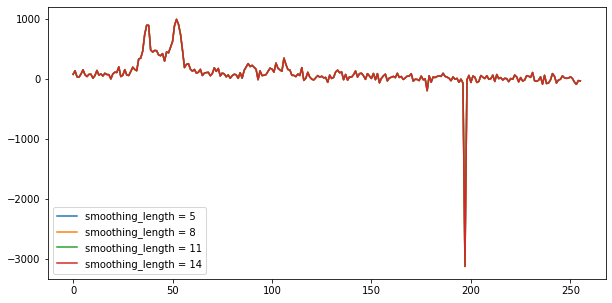

In [17]:
plt.figure(figsize=(10,5))

for smoothing_length in [5,8,11,14]:
    
    refpix_data = fits.open('pipeline_outputs_directory/smooth_length_'+str(smoothing_length)+'_refpixstep.fits')
    first_integration_group = refpix_data['SCI'].data[0,0,:,:]
    plt.plot(first_integration_group[:,1000], label = 'smoothing_length = '+str(smoothing_length))
    
plt.legend()

No difference on the smoothing length with this experiment --- and data visibly much better!

## 6. JWST `DataModels`

While working with `fits` files is all good to us astronomers, it can get cumbersome at some point as the input/output is not very straightforward. Within the JWST pipeline, folks have created `DataModels` in order to abstract the need to deal with `fits` (or any other) formats. The full documentation about them [is in the pipeline ReadTheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/datamodels/models.html). Here, we will used them to extract [WCS information](https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/main.html?highlight=exposure%20wcs#using-the-wcs-interactively), which includes wavelength information assigned to a given dataset.

As an example of how to use them, let's extract the wavelength map from the Stage 2 products of the [NIRISS simulated data](https://stsci.app.box.com/folder/137597405828?s=gzrpbb0q800u1jv3y33cepnvvj75x8qv). Before moving forward, please download the `WASP43_NIS_SOSS-seg002_CLEAR_mbias_mlinearity_1_assignwcsstep.fits` file. 

Let's first import the `datamodels`:

In [18]:
from jwst import datamodels

And let's extract the wavelength map for SOSS orders 1 and 2. We do this only for the second segment of the data --- both segments have the same wavelength information:

In [19]:
exposure = datamodels.SpecModel('WASP43_NIS_SOSS-seg002_CLEAR_mbias_mlinearity_1_assignwcsstep.fits')

The `exposure` `SpecModel` has everything we need to get the wavelength of each pixel of a given order. For instance, let's get the wavelength of column `1000` and row `200` of order `1`:

In [20]:
exposure.meta.wcs(1000, 200, 1)

(154.91, -9.81, 1.8409473896026611)

The last item of this tuple is the wavelength. The first two are the RA and DEC of the pixel! All right, let's extract the entire map of wavelengths for both orders:

In [21]:
rows, columns = 256, 2048
wavelength_maps = np.zeros([2,rows,columns])

for order in [1,2]:
    for row in range(rows):
        for column in range(columns):
            wavelength_maps[order-1,row,column] = exposure.meta.wcs(column, row, order)[-1]

Let's plot these wavelength maps:

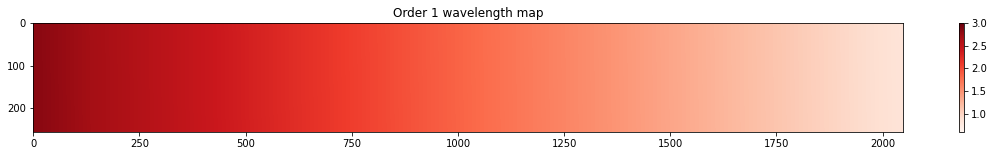

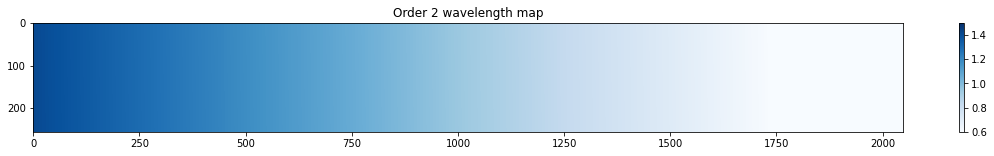

In [22]:
plt.figure(figsize=(20, 2))
plt.title('Order 1 wavelength map')
im1 = plt.imshow(wavelength_maps[0,:,:])
im1.set_clim(0.6, 3.0)
im1.set_cmap('Reds')
cb1 = plt.colorbar()

plt.figure(figsize=(20, 2))
plt.title('Order 2 wavelength map')
im2 = plt.imshow(wavelength_maps[1,:,:])
im2.set_clim(0.6, 1.5)
im2.set_cmap('Blues')
cb2 = plt.colorbar()

Nice! These can be used to identify which pixels correspond to which wavelength when performing spectral extraction.